In [1]:
'''
Updated on Mar 11 2020
'''
#資料處理套件
import pandas as pd  
#數學運算套件
import numpy as np
#繪圖套件
import matplotlib.pyplot as plt
#函數優化套件
import scipy.optimize as sco

#聯接TEJ API
import tejapi 
#輸入你的金鑰
tejapi.ApiConfig.api_key = "your key"

In [2]:
#決定資料日期範圍
sampledates = ['2020-01-01','2020-12-31']
#決定證券樣本
code=['1101','2330','2002','0050']
#從匯入報酬率資料
data_raw= tejapi.get('TWN/APRCD', coid=code ,mdate={'gte':sampledates[0],'lte':sampledates[1]},
                     opts={"sort":"mdate.desc",'columns':['coid','mdate','roi']}, paginate=True)

#查看資料樣本
data_raw.head()

,coid,mdate,roi
None,,,
0,0050,2020-12-31 00:00:00+00:00,0.5345
1,1101,2020-12-31 00:00:00+00:00,-0.1156
2,2002,2020-12-31 00:00:00+00:00,-1.0000
3,2330,2020-12-31 00:00:00+00:00,0.9524
4,0050,2020-12-30 00:00:00+00:00,1.4178


In [3]:
# 重設索引值，以日期為索引
clean = data_raw.set_index('mdate')
#資料轉置
returns = clean.pivot(columns='coid')

#欄位以股票代號命名
returns.columns = [columns[1] for columns in returns.columns]
returns.head()

,0050,1101,2002,2330
mdate,,,,
2020-01-02 00:00:00+00:00,0.7220,0.9153,0.4184,2.4169
2020-01-03 00:00:00+00:00,0.0000,-0.3401,0.4167,0.1475
2020-01-06 00:00:00+00:00,-1.2801,-1.1377,-1.2448,-2.2091
2020-01-07 00:00:00+00:00,-0.3112,0.3452,-0.4202,-0.7530
2020-01-08 00:00:00+00:00,-0.4683,-0.4587,-0.6329,0.0000


In [4]:
#計算平均報酬
mean_returns = returns.mean()
print('平均報酬\n',mean_returns )

#計算共變異數
cov_matrix = returns.cov()
print('\n共變異數矩陣\n',cov_matrix.head(5))

平均報酬
 0050    0.121227
1101    0.048143
2002    0.032413
2330    0.221668
dtype: float64

共變異數矩陣
           0050      1101      2002      2330
0050  2.147331  1.590753  1.229623  2.527191
1101  1.590753  1.992812  1.151082  1.576726
2002  1.229623  1.151082  1.633938  1.219950
2330  2.527191  1.576726  1.219950  3.600274


In [5]:
# 建立報酬率及標準差函數
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights )
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) 
    return std, returns

# 建立隨機投資組合
# 自訂投資組合數
num_portfolios = 25000

def random_portfolios(num_portfolios, mean_returns, cov_matrix):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(code))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return) / portfolio_std_dev
    return results, weights_record

In [6]:
# SAMPLE：隨機投資組合

results = np.zeros((3,num_portfolios))
weights_record = []
for i in range(num_portfolios):
    weights = np.random.random(len(code))
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_std_dev, portfolio_return = portfolio_performance(weights, mean_returns, cov_matrix)
    results[0,i] = portfolio_std_dev
    results[1,i] = portfolio_return
    results[2,i] = (portfolio_return) / portfolio_std_dev

print('-' * 100)
print('平均報酬：\n',mean_returns )
print('-' * 100)
print('投組權重：', weights_record[0])
print('-' * 100)
print('報酬率：', results[1][0])
print('-' * 100)
print('標準差：', results[0][0])
print('-' * 100)

----------------------------------------------------------------------------------------------------
平均報酬：
 0050    0.121227
1101    0.048143
2002    0.032413
2330    0.221668
dtype: float64
----------------------------------------------------------------------------------------------------
投組權重： [0.15903527 0.17247676 0.30281267 0.3656753 ]
----------------------------------------------------------------------------------------------------
報酬率： 0.11845655301339905
----------------------------------------------------------------------------------------------------
標準差： 1.3541717359460306
----------------------------------------------------------------------------------------------------


No handles with labels found to put in legend.


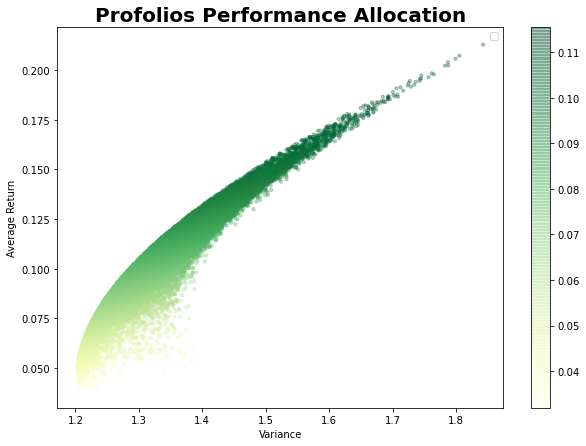

In [7]:
# 投資組合散佈圖

def profolios_allocation(mean_returns, cov_matrix, num_portfolios):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix)
      
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGn', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.title('Profolios Performance Allocation', fontsize=20,fontweight='bold',)
    plt.xlabel('Variance')
    plt.ylabel('Average Return')
    plt.legend(labelspacing=0.8)
    plt.show()
    
profolios_allocation(mean_returns, cov_matrix, num_portfolios)

In [8]:
# 建立風險函數
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

# 找出投資組合中最小風險
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0,1)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1/num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

#找到相同投資組合報酬率下最小的風險
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1/num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

#找到效率前緣樣本
def efficient_profolios(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

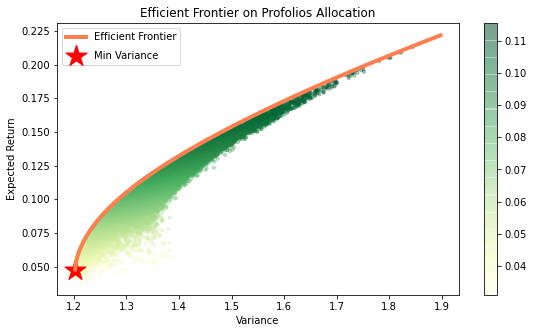

In [9]:
def display_efficient_frontier(mean_returns, cov_matrix, num_portfolios):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix)
     
    #點出所有投組報酬率及風險
    plt.figure(figsize=(9, 5))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGn', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    
    #找出最小風險投資組合及其報酬率
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_performance(min_vol['x'], mean_returns, cov_matrix)
    
    #點出最小風險之投資組合
    plt.scatter(sdp_min,rp_min,marker='*',color='red',s=500, label='Min Variance')

    #畫出所有投組樣本的效率前緣線    
    target = np.linspace(rp_min, mean_returns.max(), 50)
    efficient_portfolios = efficient_profolios(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], 
             target, linestyle='-', color='coral',linewidth=4, label='Efficient Frontier') 
    plt.title('Efficient Frontier on Profolios Allocation')
    plt.xlabel('Variance')
    plt.ylabel('Expected Return')
    plt.legend(labelspacing=0.9 ,loc ='upper left')
    plt.show()
    
display_efficient_frontier(mean_returns, cov_matrix, num_portfolios)